In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing 
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

##  Goal

The notebook demonstrates 3 usecases for implementing models by instructing it how to arrive at the output


In [3]:
def print_results(result, X_train, y_train, X_test, y_test):
     
    """
    The function takes in a fitted model and training and test data and prints the best params and training and test set performance 
    """
    
    print("XGB Model best params : {}".format(result.best_params_))
    
    ypred_train = result.predict(X_train)
    mse_train = mean_squared_error(y_train, ypred_train)
    print(" Train RMSE: %.5f" % (mse_train**(1/2.0)))
    
    ypred_test = result.predict(X_test)
    mse_test = mean_squared_error(y_test, ypred_test)
    print(" Test RMSE: %.5f" % (mse_test**(1/2.0)))

In [4]:
def get_partial_dependence(res, feature, X, y):
    """
    The function takes in a fitted model, data and a feature of X and takes a sample of 50 feature values called grid and
    calculates partial dependence.The partial function tells us for given value(s) of feature what is the average 
    marginal effect on the model prediction
    """
    data = X.copy()
    grid = np.linspace(np.percentile(data.loc[:, feature], 0.1),
                       np.percentile(data.loc[:, feature], 99.5),
                    50)
    y_pred = np.zeros(50)
    for i, val in enumerate(grid):
                data.loc[:, feature] = val
                pred = res.predict(data)
                y_pred[i] = np.average(pred)
    
    return grid, y_pred

### Read Data 

To demonstrate Usecase 1 and 2 we use an Expenditures dataset found here: [link](https://www.kaggle.com/wduckett/californiaddsexpenditures). It has 1000 rows and 5 columns -  Age, Age Cohort, Gender, Ethnicity and Expenditures.To implement usecase 1 and 2 we create one Baseline XGBoost Model, one XGBoost Model with a monotone constraint on Age and another XGBoost Model with monotone constraint on synthetic variables derived from Age to predict Expenditure

In [5]:
df = pd.read_csv("californiaDDSDataV2.csv")
df = df.drop(columns = 'Id')
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


### Data Exploration / Engineering

In [6]:
df.isnull().sum()

Age Cohort      0
Age             0
Gender          0
Expenditures    0
Ethnicity       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
Age Cohort      1000 non-null object
Age             1000 non-null int64
Gender          1000 non-null object
Expenditures    1000 non-null int64
Ethnicity       1000 non-null object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [8]:
df.shape

(1000, 5)

In [9]:
df["Ethnicity"].value_counts()

White not Hispanic    401
Hispanic              376
Asian                 129
Black                  59
Multi Race             26
American Indian         4
Native Hawaiian         3
Other                   2
Name: Ethnicity, dtype: int64

In [10]:
df.groupby('Ethnicity')[["Age"]].mean()

,Age
Ethnicity,
American Indian,53.250000
Asian,23.069767
Black,24.644068
Hispanic,17.375000
Multi Race,10.269231
Native Hawaiian,35.666667
Other,16.000000
White not Hispanic,27.975062


For the purpose of this example we select rows havng ethnicity Hispanic or White not Hispanic which forms a majority of the dataset.

In [11]:
df = df[(df["Ethnicity"] == 'Hispanic') | (df["Ethnicity"] == 'White not Hispanic')]
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


In [12]:
df.shape

(777, 5)

In [13]:
df.groupby(['Ethnicity'])[["Expenditures"]].mean()

,Expenditures
Ethnicity,
Hispanic,11065.569149
White not Hispanic,24697.548628


In [14]:
df2= df.groupby(['Ethnicity', 'Age Cohort'])[["Expenditures"]].mean().reset_index()
df2

,Ethnicity,Age Cohort,Expenditures
0,Hispanic,0 to 5,1393.204545
1,Hispanic,13 to 17,3955.281553
2,Hispanic,18 to 21,9959.846154
3,Hispanic,22 to 50,40924.116279
4,Hispanic,51+,55585.000000
5,Hispanic,6 to 12,2312.186813
6,White not Hispanic,0 to 5,1366.900000
7,White not Hispanic,13 to 17,3904.358209
8,White not Hispanic,18 to 21,10133.057971
9,White not Hispanic,22 to 50,40187.624060


In [15]:
pd.merge(df2[df2['Ethnicity'] == 'Hispanic'], df2[df2['Ethnicity'] == 'White not Hispanic'], on='Age Cohort')

,Ethnicity_x,Age Cohort,Expenditures_x,Ethnicity_y,Expenditures_y
0,Hispanic,0 to 5,1393.204545,White not Hispanic,1366.900000
1,Hispanic,13 to 17,3955.281553,White not Hispanic,3904.358209
2,Hispanic,18 to 21,9959.846154,White not Hispanic,10133.057971
3,Hispanic,22 to 50,40924.116279,White not Hispanic,40187.624060
4,Hispanic,51+,55585.000000,White not Hispanic,52670.424242
5,Hispanic,6 to 12,2312.186813,White not Hispanic,2052.260870


In [16]:
df3= df.groupby(['Age Cohort', 'Gender'])[["Expenditures"]].mean().reset_index()
df3

,Age Cohort,Gender,Expenditures
0,0 to 5,Female,1387.896552
1,0 to 5,Male,1382.571429
2,13 to 17,Female,3948.068966
3,13 to 17,Male,3921.734940
4,18 to 21,Female,10317.935065
5,18 to 21,Male,9736.685714
6,22 to 50,Female,41797.166667
7,22 to 50,Male,39062.271739
8,51+,Female,54436.857143
9,51+,Male,52069.390244


In [17]:
pd.merge(df3[df3['Gender'] == 'Male'], df3[df3['Gender'] == 'Female'], on='Age Cohort')

,Age Cohort,Gender_x,Expenditures_x,Gender_y,Expenditures_y
0,0 to 5,Male,1382.571429,Female,1387.896552
1,13 to 17,Male,3921.734940,Female,3948.068966
2,18 to 21,Male,9736.685714,Female,10317.935065
3,22 to 50,Male,39062.271739,Female,41797.166667
4,51+,Male,52069.390244,Female,54436.857143
5,6 to 12,Male,2070.220339,Female,2341.923077


In [18]:
df['Gender']= preprocessing.LabelEncoder().fit_transform(df['Gender']) 
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,0,2113,White not Hispanic
1,22 to 50,37,1,41924,White not Hispanic
2,0 to 5,3,1,1454,Hispanic
3,18 to 21,19,0,6400,Hispanic
4,13 to 17,13,1,4412,White not Hispanic


In [19]:
df.shape

(777, 5)

For the purpose of this example we transform the Expenditure variable such that for rows with Age above 75 the Expenditure is divided by half

In [20]:
df['Expenditures_Old'] = df['Expenditures']
df.loc[df['Age']>75, 'Expenditures'] = df.loc[df['Age']>75, 'Expenditures']/2

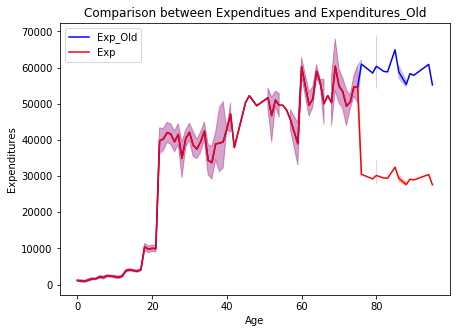

In [21]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(7, 5)
sns.lineplot(data=df, x="Age", y="Expenditures_Old", color='blue')
sns.lineplot(data=df, x="Age", y="Expenditures", color='red')
plt.title("Comparison between Expenditues and Expenditures_Old") 
plt.legend(labels=["Exp_Old","Exp"])
plt.show()

In [22]:
X = df[["Age", "Gender"]]
y = df["Expenditures"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [23]:
X_train.shape

(621, 2)

## Usecase 1: The model prediction must be a decreasing (or increasing) function of x1¶

To demonstrate this usecase we add a monotone constraint on age and make the assumption that expenditure should increase with age

In [24]:
param_grid = {
                'max_depth': [3], 
                'learning_rate': [.05], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [25, 30, 40, 50, 100, 150],
                'reg_gamma': [0.5]
}

xgbr = xgb.XGBRegressor()
gr = GridSearchCV(xgbr,param_grid=param_grid,cv=5, verbose=True)
res = gr.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


In [25]:
print_results(res, X_train, y_train, X_test, y_test)

XGB Model best params : {'n_estimators': 100, 'random_state': 123, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'max_depth': 3, 'reg_gamma': 0.5}
 Train RMSE: 3207.41317
 Test RMSE: 4012.14143


Text(0, 0.5, 'Features')

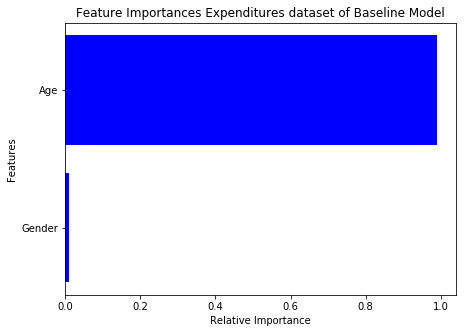

In [26]:
features = X_train.columns
importances = res.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 5))
plt.title('Feature Importances Expenditures dataset of Baseline Model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')

### Adding monotone contraint on Age 

In [27]:
param_dict = param_grid
param_dict['monotone_constraints'] = ["(1,0)"]

In [28]:
xgbr_2 = xgb.XGBRegressor()
gr2 = GridSearchCV(xgbr_2,param_grid=param_dict,cv=5, verbose=True)
res2 = gr2.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


In [29]:
print_results(res2, X_train, y_train, X_test, y_test)

XGB Model best params : {'n_estimators': 100, 'random_state': 123, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'max_depth': 3, 'reg_gamma': 0.5, 'monotone_constraints': '(1,0)'}
 Train RMSE: 4383.91389
 Test RMSE: 5584.70953


Text(0, 0.5, 'Features')

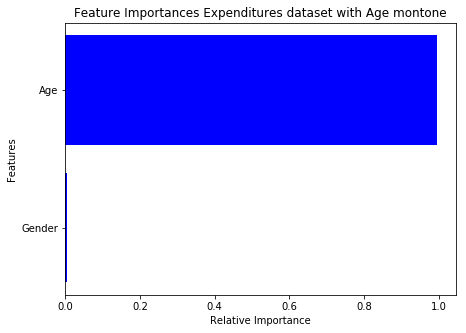

In [30]:
features = X_train.columns
importances = res2.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 5))
plt.title('Feature Importances Expenditures dataset with Age montone')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')

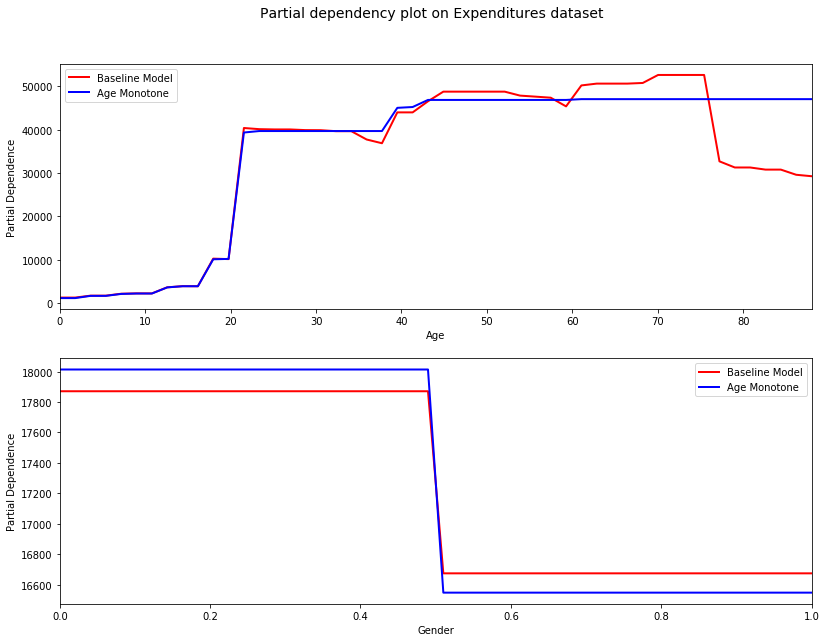

In [31]:
features = X_train.columns
fig, ax = plt.subplots(2,1)
fig.set_size_inches(12, 10)
fig.suptitle('Partial dependency plot on Expenditures dataset', fontsize=14)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
for i, f in enumerate(features):
    grid, y_pred = get_partial_dependence(res, f, X_train, y_train)
    grid2, y_pred2 = get_partial_dependence(res2, f, X_train, y_train)
    ax = ax.flatten()
    axis = ax[i]
    axis.plot(grid, y_pred, color = 'red', linewidth = 2, label='Baseline Model')
    axis.plot(grid2, y_pred2, color = 'blue', linewidth = 2, label='Age Monotone')
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 10)
    axis.set_ylabel('Partial Dependence', fontsize = 10)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 10)

In [32]:
df['y_pred'] = res.predict(X)
df['y_pred2'] = res2.predict(X)

## Usecase 2: The model prediction must be a U-shaped function of x2

To demonstrate this usecase we create two new variables Age_Plus which is defined as min(Age, 75) and Age_Minus which is defined as max(75, Age) and make the assumption that expenditure is a U shaped function of Age. 

In [33]:
df['Age_plus'] = df['Age']
df.loc[df['Age']>75, 'Age_Plus'] = 75
df['Age_minus'] = df['Age']
df.loc[df['Age']<=75, 'Age_minus'] = 75
param_dict = param_grid
param_dict['monotone_constraints'] = ["(1,-1, 0)"]

In [34]:
X = df[["Age_plus", "Age_minus", "Gender"]]
y = df["Expenditures"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)


xgbr_age_kink = xgb.XGBRegressor()
gr3 = GridSearchCV(xgbr_age_kink,param_grid=param_dict,cv=5, verbose=True)
age_kink_model = gr3.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.7s finished


In [35]:
df['y_pred3'] = age_kink_model.predict(X)

In [36]:
print_results(age_kink_model, X_train, y_train, X_test, y_test)

XGB Model best params : {'n_estimators': 100, 'random_state': 123, 'objective': 'reg:squarederror', 'learning_rate': 0.05, 'max_depth': 3, 'reg_gamma': 0.5, 'monotone_constraints': '(1,-1, 0)'}
 Train RMSE: 3330.69892
 Test RMSE: 3969.49170


Text(0, 0.5, 'Features')

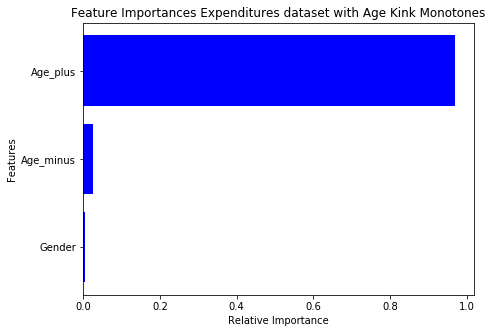

In [37]:
features = X_train.columns
importances = age_kink_model.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 5))
plt.title('Feature Importances Expenditures dataset with Age Kink Monotones')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')

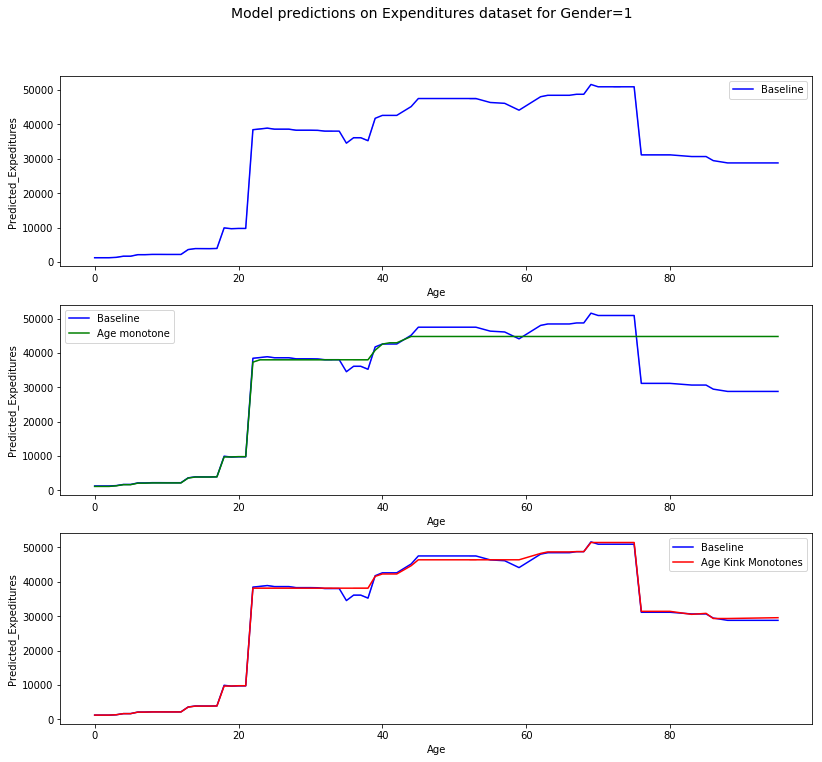

In [38]:
f, ax = plt.subplots(3, 1)
f.set_size_inches(12, 12)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
ax = ax.flatten()
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred", color='blue', ax=ax[0])
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Predicted_Expeditures')
ax[0].legend(labels = ['Baseline'])
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred", color='blue', ax = ax[1])
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred2", color='green', ax = ax[1])
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Predicted_Expeditures')
ax[1].legend(labels = ['Baseline', 'Age monotone'])
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred", color='blue', ax = ax[2])
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred3", color='red', ax = ax[2])
ax[2].set_xlabel('Age')
ax[2].set_ylabel('Predicted_Expeditures')
ax[2].legend(labels = ['Baseline', 'Age Kink Monotones'])
f.suptitle("Model predictions on Expenditures dataset for Gender=1", fontsize=14)
plt.show()

## Usecase 3: The model prediction must not be too sensitive to x3

An example for implementing this usecase is the Boston Housing toy dataset imported from sklearn datasets. It has 506 rows and 13 attributes.To implement use case 3  we will create two XGBoost models. The first model will be trained on the whole dataset and the second will be trained on a subset of the dataset.The final prediction will be a weighted average of these two models. 

In [39]:
boston_dataset = load_boston()
print(boston_dataset.keys())

dict_keys(['target', 'feature_names', 'DESCR', 'filename', 'data'])


In [40]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [41]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.drop(columns=['B', 'LSTAT'], inplace=True)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,36.2


In [42]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
MEDV       0
dtype: int64

In [43]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 12 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
MEDV       506 non-null float64
dtypes: float64(12)
memory usage: 47.6 KB


In [44]:
X, y = boston.iloc[:,:-1], boston.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

[17:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 0, 'Relative Importance')

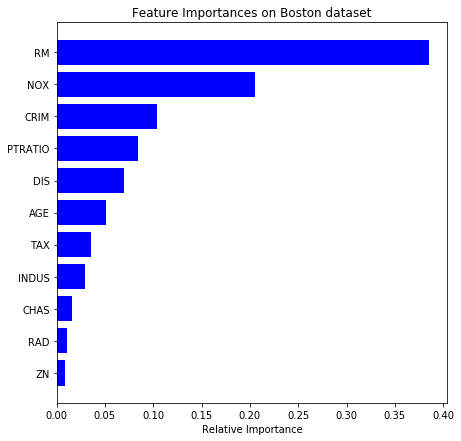

In [45]:
model1 = xgb.XGBRegressor(n_estimators=100)
result1 = model1.fit(X_train,y_train)

features = X_train.columns
importances = result1.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.title('Feature Importances on Boston dataset')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

From the plot above it can be seen that the model is very sensitive to RM. We will create a blended model which takes the weighted average of two models one trained on all features including RM and one trained on all features excluding RM.

In [46]:
class ColumnSelector(object):
    """
    A feature selector for scikit-learn's Pipeline class that returns
    specified columns from a numpy array.

    """

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X.iloc[:, self.cols]

    def fit(self, X, y=None):
        return self

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

pipe1 = Pipeline([
               ('sel', ColumnSelector([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])),
               ('clf', xgb.XGBRegressor())
])

pipe2 = Pipeline([
               ('sel', ColumnSelector([0, 1, 2, 3, 4, 6, 7, 8, 9, 10])),
               ('clf', xgb.XGBRegressor())]
        )

[17:23:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:34] WARNI

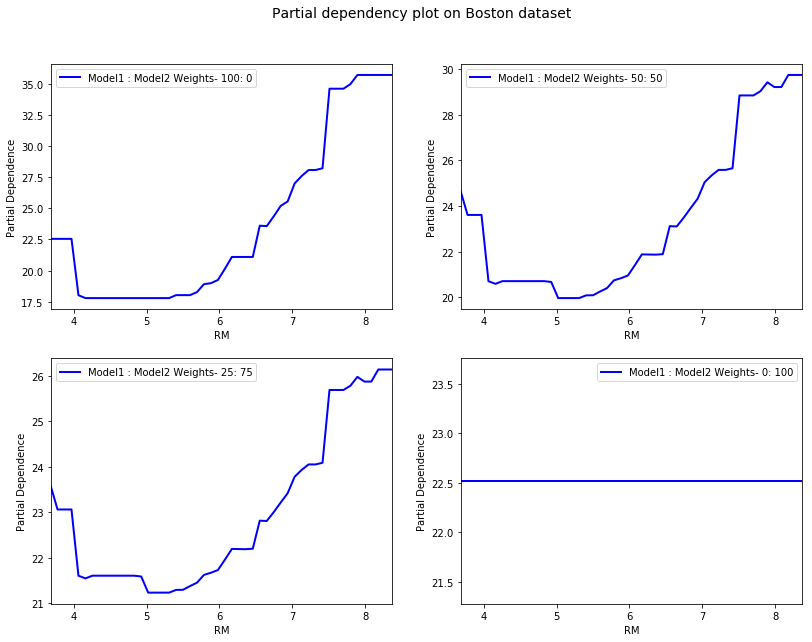

In [50]:
alphas = [100, 50, 25 , 0]
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 10)
fig.suptitle('Partial dependency plot on Boston dataset', fontsize=14)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
for i, alpha in enumerate(alphas):
    er = VotingRegressor([('p1', pipe1),
                          ('p2', pipe2)], [alpha, 100-alpha])
    pipe3 = Pipeline([
               ('eclf', er),
     ])
    parameters = {
    'eclf__p1__clf__n_estimators':[25, 30, 40, 50, 100, 150],
    'eclf__p2__clf__n_estimators':[25, 30, 40, 50, 100, 150],
    }
    grid_search = GridSearchCV(pipe3, parameters, n_jobs=-1, cv=5)
    res = grid_search.fit(X_train, y_train)
    grid, y_pred = get_partial_dependence(res, 'RM', X_train, y_train)
    ax = ax.flatten()
    axis = ax[i]
    label = "Model1 : Model2 Weights- " + str(alpha) + ": " + str(100-alpha)
    axis.plot(grid, y_pred, color = 'blue', linewidth = 2, label=label)
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel('RM', fontsize = 10)
    axis.set_ylabel('Partial Dependence', fontsize = 10)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 10)